In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow.compat.v1 as tf 
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
sns.set(style='whitegrid',palette='muted',font_scale=1.5)

In [ ]:
RANDOM_SEED = 42

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('/content/drive/MyDrive/WISDM.txt', header=None, names = columns)
df = df.dropna()
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [ ]:
df.tail()

,user,activity,timestamp,x-axis,y-axis,z-axis
1098202,19,Sitting,131623331483000,9.00,-1.57,1.69
1098203,19,Sitting,131623371431000,9.04,-1.46,1.73
1098204,19,Sitting,131623411592000,9.08,-1.38,1.69
1098205,19,Sitting,131623491487000,9.00,-1.46,1.73
1098206,19,Sitting,131623531465000,8.88,-1.33,1.61


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098206 entries, 0 to 1098206
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098206 non-null  int64  
 1   activity   1098206 non-null  object 
 2   timestamp  1098206 non-null  int64  
 3   x-axis     1098206 non-null  float64
 4   y-axis     1098206 non-null  float64
 5   z-axis     1098206 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [ ]:
v1 = lambda x:float(x[1:-1])

In [ ]:
#df.z_axis = df.z_axis.apply(v1)

In [ ]:
countOfActivity = df['activity'].value_counts()
print(countOfActivity)

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
walking            3
Name: activity, dtype: int64


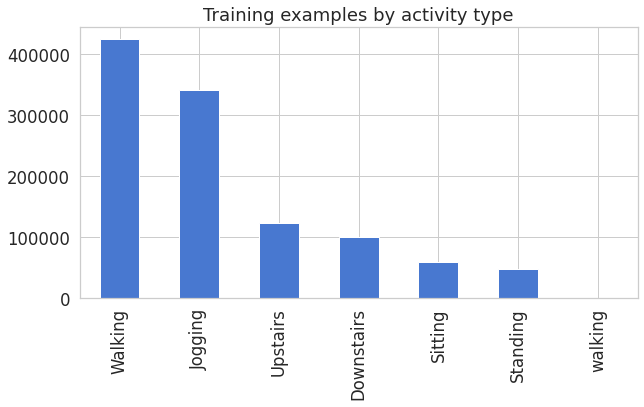

In [ ]:
countOfActivity.plot(kind = 'bar', title = 'Training examples by activity type' , figsize = (10,5));

In [ ]:
countOfActivityPerPerson=df['user'].value_counts()
print(countOfActivityPerPerson)
totalActivity=countOfActivityPerPerson.sum()
print("Total number of activity recorded ="+ str(totalActivity))

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35507
21    35436
3     35161
27    34958
10    34883
18    32813
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28509
15    28154
24    25736
23    25673
30    25335
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user, dtype: int64
Total number of activity recorded =1098206


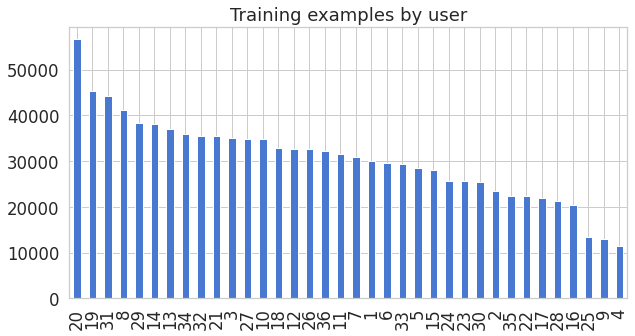

In [ ]:
countOfActivityPerPerson.plot(kind='bar', title='Training examples by user', figsize=(10,5));

In [ ]:
def plot_activity(activity,df):
  extractRowsofActivity = (df['activity']==activity)
  data=df[extractRowsofActivity]
  data=data[['x-axis', 'y-axis', 'z-axis']]
  data=data[:500]
  ax=data.plot(subplots=True, figsize=(14,8), title=activity)

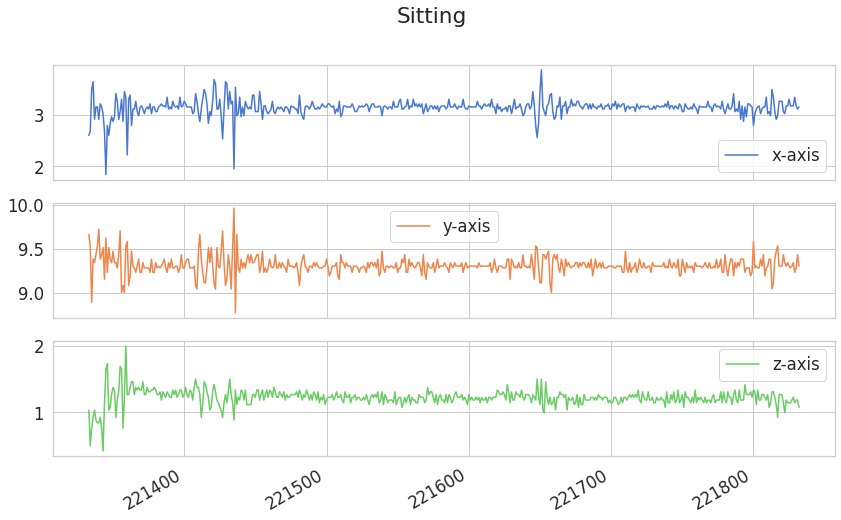

In [ ]:
plot_activity("Sitting" , df)

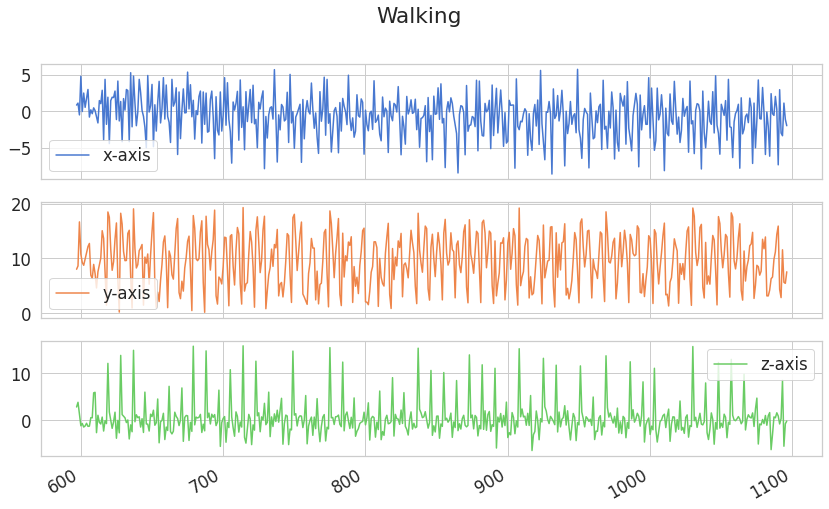

In [ ]:
plot_activity("Walking",df)

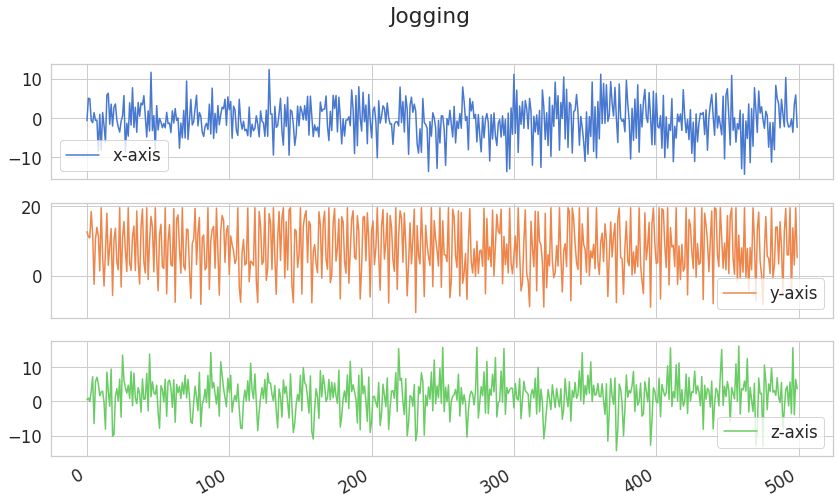

In [ ]:
plot_activity("Jogging",df)

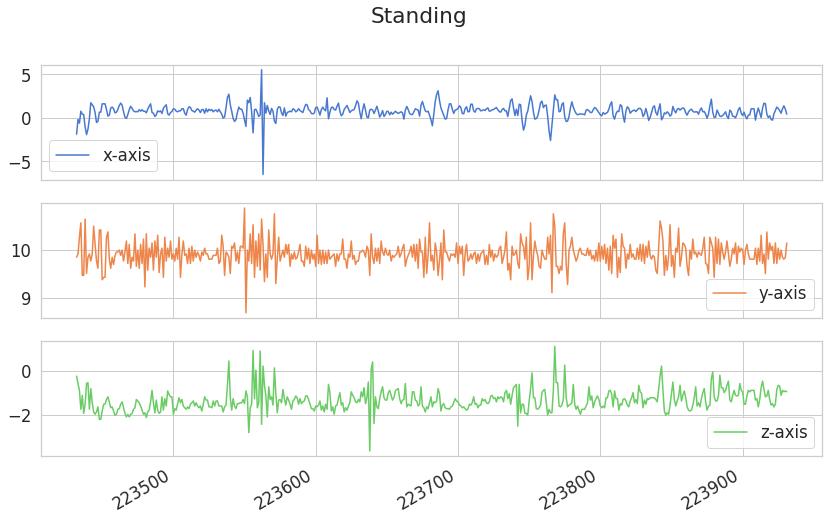

In [ ]:
plot_activity("Standing",df)

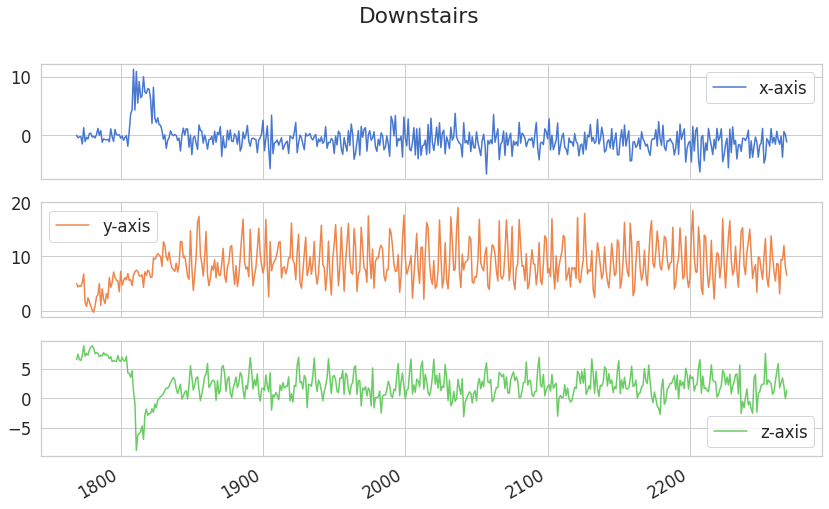

In [ ]:
plot_activity("Downstairs",df)

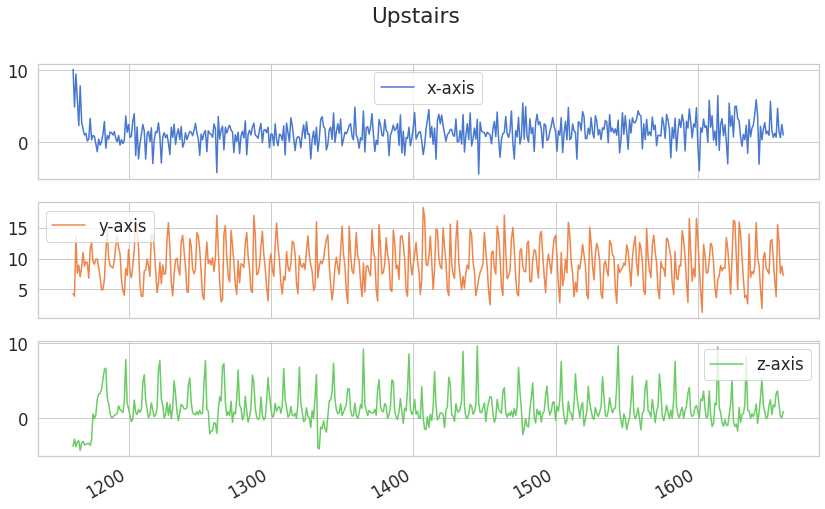

In [ ]:
plot_activity("Upstairs",df)

In [ ]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0,len(df) - N_TIME_STEPS, step):
  xs = df['x-axis'].values[i: i + N_TIME_STEPS]
  ys = df['y-axis'].values[i: i + N_TIME_STEPS]
  zs = df['z-axis'].values[i: i + N_TIME_STEPS]
  label = stats.mode(df['activity'][i: i + N_TIME_STEPS])
  label = label[0][0]
  segments.append([xs,ys,zs])
  labels.append(label)

In [ ]:
np.array(segments).shape

(54901, 3, 200)

In [ ]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segments.shape

(54901, 200, 3)

In [ ]:
labels = np.asarray(pd.get_dummies(labels), dtype= np.float32)

In [ ]:
print(labels)
print(labels.shape)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
(54901, 6)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state=RANDOM_SEED)

In [ ]:
len(x_train)

43920

In [ ]:
len(x_test)


10981

In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [ ]:
tf.compat.v1.disable_eager_execution()

def create_LSTM_model(inputs):
  w = { 
      'hidden': tf.Variable(tf.random.normal([N_FEATURES,  N_HIDDEN_UNITS])),
       'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
  }
  biases = {
      'hidden': tf.Variable(tf.compat.v1.random_normal([N_HIDDEN_UNITS], mean=1.0)),
      'output': tf.Variable(tf.compat.v1.random_normal([N_CLASSES]))
  }
  x = tf.transpose(inputs,[1,0,2])
  x = tf.reshape(x, [-1, N_FEATURES])
  hidden = tf.nn.relu(tf.matmul(x, w['hidden']) + biases['hidden'])
  hidden = tf.split(hidden, N_TIME_STEPS, 0)

  lstm_layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
  lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)

  outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

  lstm_last_output = outputs[-1]

  return tf.matmul(lstm_last_output, w['output']) + biases['output']
  

In [ ]:
tf.compat.v1.reset_default_graph()

x = tf.compat.v1.placeholder(tf.float32, [None , N_TIME_STEPS, N_FEATURES], name="input" )
y = tf.compat.v1.placeholder(tf.float32,  [None , N_CLASSES])

In [ ]:
pred_Y = create_LSTM_model(x)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


In [ ]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in  tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = y)) + l2


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
LEARNING_RATE = 0.00025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(y, 1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

saver = tf.train.Saver()

history = dict(train_loss=[],
                     train_acc=[],
                     test_loss=[],
                     test_acc=[])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(x_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={x: x_train[start:end],
                                   y: y_train[start:end]})
    
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            x: x_train, y:y_train})
    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            x:x_test, y:y_test})
    
    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i==1 or i%10==0:
     print(f'epoch: {i} test accuracy: {acc_test} test loss: {loss_test} train accuracy:{acc_train} train loss:{loss_train}')
      


prediction, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict = {x: x_test, y:y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final} train accuracy:{acc_train} train loss:{loss_train}')




epoch: 1 test accuracy: 1.0 test loss: 1.7498579025268555 train accuracy:1.0 train loss:1.748373031616211
epoch: 10 test accuracy: 1.0 test loss: 1.0064103603363037 train accuracy:1.0 train loss:1.0034153461456299
epoch: 20 test accuracy: 1.0 test loss: 0.8578139543533325 train accuracy:1.0 train loss:0.8452466726303101
epoch: 30 test accuracy: 1.0 test loss: 0.7875088453292847 train accuracy:1.0 train loss:0.7619951963424683
epoch: 40 test accuracy: 1.0 test loss: 0.732418954372406 train accuracy:1.0 train loss:0.7062853574752808
epoch: 50 test accuracy: 1.0 test loss: 0.6758276224136353 train accuracy:1.0 train loss:0.6414243578910828

final results: accuracy: 1.0 loss: 0.6758276224136353 train accuracy:1.0 train loss:0.6414243578910828


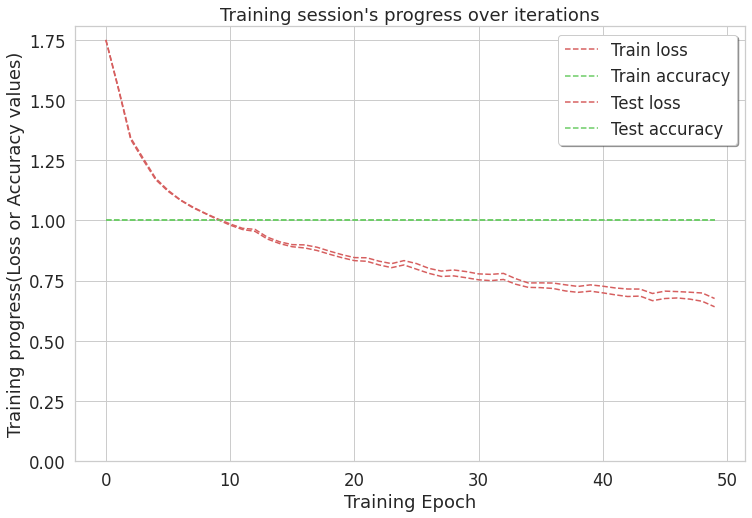

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(np.array(history['train_loss']),"r--",label = "Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r--", label="Test loss")
plt.plot(np.array(history['test_acc']), "g--", label = "Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training progress(Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

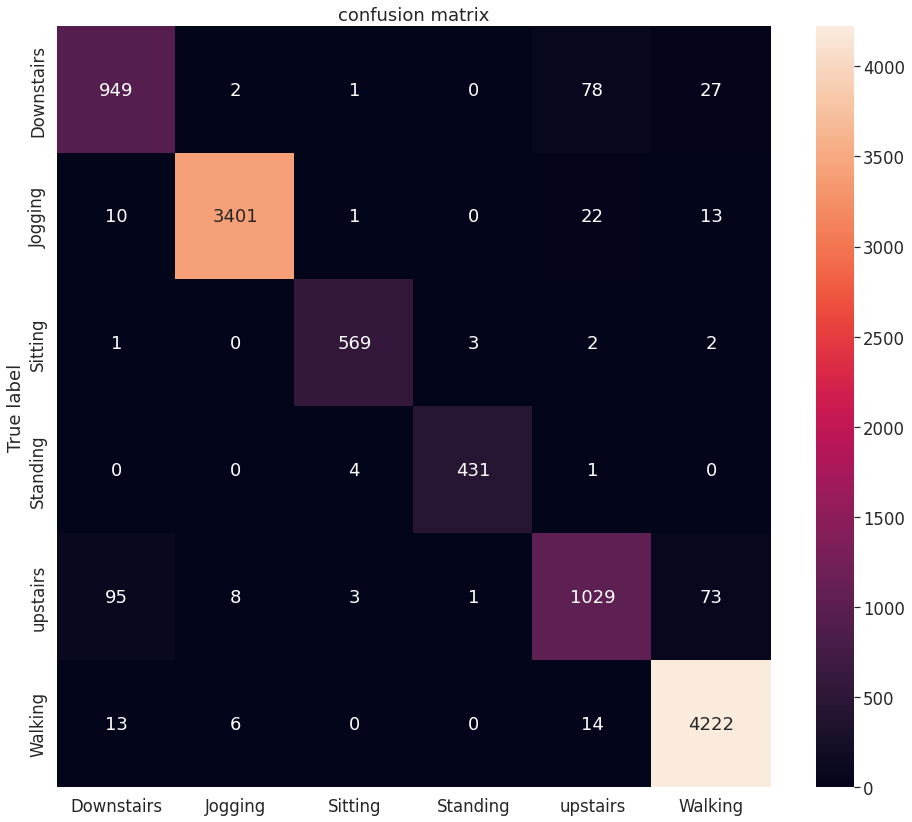

In [ ]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'upstairs', 'Walking']

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(prediction, axis=1)
confusion_matrix= metrics.confusion_matrix(max_test,max_predictions)

plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot =True, fmt="d");
plt.title("confusion matrix")
plt.ylabel('True label')
plt.show()